In [3]:
import os
import sys
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from scipy.signal import welch, firwin, filtfilt, hilbert
from scipy.stats.stats import pearsonr, spearmanr
from scipy.stats import chi2_contingency
from time import gmtime
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.cluster import KMeans
from scipy.stats import wilcoxon

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [32]:
sys.path.insert(0, '/Users/wassilyminkow/Scripts/Python3/Neuroinformatics/')

from torpor_project.data import *

In [29]:
pylab.rcParams['figure.figsize'] = (22, 18)
sns.set(font_scale=3)

In [11]:
file = "/Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_without_torpor.csv"

In [12]:
data = pd.read_csv(file)

dG - отклонение ускорения в момент измерения от 0 (ускорения свободного падения); если животное падает, то ускорение животного равно G и соответственно dG будет равно 1

dF1, dF2 - изменение направления вектора ускорения, причем dF1 - изменение за время между двумя измерениями (1 минута), а  dF2 - изменение между двумя измерениями с интервалом 1 мс - если оно не равно 0, то обычно животное изменяет свое положение.
 
Все показатели измеряются раз в минуту, если период измерения  указан больше, чем минута, то показатели усредняются за этот период. Если надо, то изготовитель может прислать точную формулу расчета этих показателей.

In [22]:
data

,Page,Record,Period,Year,Month,Day,Hour,Minute,Second,Ubat,T,dG,dF1,dF2
0,8,13,10,2019,1,19,3,45,0,3.0,36.489,0.031,11,3
1,8,14,10,2019,1,19,3,55,0,3.0,36.758,0.062,17,6
2,9,1,10,2019,1,19,4,5,0,3.0,36.731,0.078,12,4
3,9,2,10,2019,1,19,4,15,0,3.0,36.699,0.094,1,0
4,9,3,10,2019,1,19,4,25,0,3.0,36.673,0.094,3,1
5,9,4,10,2019,1,19,4,35,0,3.0,36.647,0.094,1,1
6,9,5,10,2019,1,19,4,45,0,3.0,36.673,0.094,2,1
7,9,6,10,2019,1,19,4,55,0,3.0,36.743,0.078,1,1
8,9,7,10,2019,1,19,5,5,0,3.0,36.807,0.078,1,1
9,9,8,10,2019,1,19,5,15,0,3.0,36.929,0.094,2,1


In [26]:
path = "/Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_1_records/"

In [27]:
for name in os.listdir(path):
    raw_data = mne.io.read_raw_edf(path+name)
    print(raw_data.info)

Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_2_records/01-02-2019_14-57.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-27-90e535dc784d>:2: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+name)


<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Channel 1, Channel 2, STI 014
    chs : list | 3 items (EEG: 2, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 125.00212503612562 Hz
    meas_date : tuple | 2019-02-01 14:57:03 GMT
    nchan : int | 3
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 250.00425007225124 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xpl

<ipython-input-27-90e535dc784d>:2: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+name)


<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Channel 1, Channel 2, STI 014
    chs : list | 3 items (EEG: 2, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 250.00425007225124 Hz
    meas_date : tuple | 2019-01-25 19:22:36 GMT
    nchan : int | 3
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 500.0085001445025 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplo

<ipython-input-27-90e535dc784d>:2: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+name)


<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Channel 1, Channel 2, STI 014
    chs : list | 3 items (EEG: 2, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 124.99925000449998 Hz
    meas_date : tuple | 2019-01-31 13:40:38 GMT
    nchan : int | 3
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 249.99850000899997 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xpl

<ipython-input-27-90e535dc784d>:2: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+name)


<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Channel 1, Channel 2, STI 014
    chs : list | 3 items (EEG: 2, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 124.99725006049867 Hz
    meas_date : tuple | 2019-02-06 18:01:11 GMT
    nchan : int | 3
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 249.99450012099734 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xpl

<ipython-input-27-90e535dc784d>:2: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+name)


<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Channel 1, Channel 2, STI 014
    chs : list | 3 items (EEG: 2, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 125.00225004050073 Hz
    meas_date : tuple | 2019-02-04 13:40:40 GMT
    nchan : int | 3
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 250.00450008100145 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xpl

<ipython-input-27-90e535dc784d>:2: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+name)


<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Channel 1, Channel 2, STI 014
    chs : list | 3 items (EEG: 2, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 249.97775198007378 Hz
    meas_date : tuple | 2019-01-29 15:54:17 GMT
    nchan : int | 3
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 499.95550396014755 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xpl

<ipython-input-27-90e535dc784d>:2: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+name)


<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Channel 1, Channel 2, STI 014
    chs : list | 3 items (EEG: 2, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 250.00425007225124 Hz
    meas_date : tuple | 2019-01-28 15:40:31 GMT
    nchan : int | 3
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 500.0085001445025 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplo

In [17]:
fs = round(raw_data.info["sfreq"])

In [18]:
df = pd.DataFrame(raw_data.get_data().T)

In [19]:
order = 400 # filter order
a = 1 

band = np.array([1, 4])    
b = firwin(order, band * 2 / fs, width=None, window='hamming', pass_zero=False)  # design filter

In [20]:
df = pd.DataFrame(filtfilt(b, a, df.iloc[10000:20000, :].T).T) # apply filter

/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the f

In [51]:
# read EEG and acceleration data
raw_data = mne.io.read_raw_edf(path+os.listdir(path)[0])
df = pd.DataFrame(raw_data.get_data([0, 1]), index=[raw_data.ch_names[0], raw_data.ch_names[1]]).T

# get the time when the recording was started
start = list(gmtime(raw_data.info['meas_date'][0]))

# Calculate number of samples to skip till the begining of the epoch. 
# This step is needed due to the fact, that EEG recording starts not at the same time as polygraph recording. 
n_skip = skip_damaged_epoch(start)

df_new = df.iloc[n_skip:, ]

min_per_epoch = 5

n_epocs = int(np.floor(df_new.shape[0]/fs/SEC_PER_MIN/min_per_epoch))
n_samples = int(n_epocs*min_per_epoch*SEC_PER_MIN*fs)

df_epocs = df_new.iloc[:n_samples, :]

start_epoc = temp[(temp['Year']==start[0])&(temp['Month']==start[1])&(temp['Day']==start[2])&(temp['Hour']==start[3])&(temp['Minute']==start[4])].index[0]

temp_epocs = temp.iloc[start_epoc:start_epoc+n_epocs, -1]

n_slises = 20
# step = fs*60*10

# order = 400 # filter order
# a = 1 

# band = np.array([1, 4])    
# b = firwin(order, band * 2 / fs, width=None, window='hamming', pass_zero=False)  # design filter
# df_epocs_low = filtfilt(b, a, df_epocs.iloc[:, 0]) # apply filter

# band = np.array([4, 8])    
# b = firwin(order, band * 2 / fs, width=None, window='hamming', pass_zero=False)  # design filter
# df_epocs_hi = filtfilt(b, a, df_epocs.iloc[:, 0])

# sum_power_low = np.array(list(map(lambda i: (df_epocs_low[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs))))
# sum_power_hi = np.array(list(map(lambda i: (df_epocs_hi[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs))))
# sum_power = np.array(list(map(lambda i: (df_epocs.iloc[i*step:(i+1)*step, 0]**2).mean(), np.arange(n_epocs))))
# sum_a = np.array(list(map(lambda i: (np.abs(df_epocs.iloc[i*step:(i+1)*step, 1]-df_epocs.iloc[i*step:(i+1)*step, 1].mean())).mean(), np.arange(n_epocs))))

# temp.iloc[start_epoc:start_epoc+n_epocs,-4] = sum_power_low*1e3
# temp.iloc[start_epoc:start_epoc+n_epocs,-3] = sum_power_hi*1e3
# temp.iloc[start_epoc:start_epoc+n_epocs,-2] = sum_power*1e3
# temp.iloc[start_epoc:start_epoc+n_epocs,-1] = sum_a*1e-1

# del df_epocs_low, df_epocs_hi, sum_power_low, sum_power_hi, sum_power, sum_a, raw_data, df, df_new

Extracting EDF parameters from /Users/wassilyminkow/Data/Hamster_Data/hamster_without_torpor/hamster_1_records/31-01-2019_13-39.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-51-786aa8ce87ec>:2: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+os.listdir(path)[0])


In [52]:
start

[2019, 1, 31, 13, 39, 52, 3, 31, 0]

In [260]:
def colourful_cross_correlation():

    time_array = np.arange(x.shape[0])

    gap = 6 * 24 # set size of the rolling window 

    p = np.zeros(x.shape[0]-gap) # p-value vector
    c = np.zeros(x.shape[0]-gap) # statistic vector

    # calculate the rolling corelation coefficient
    for i in np.arange(x.shape[0]-gap):
        ans = spearmanr(x[i:i+gap], y[i:i+gap])
        c[i] = ans[0] 
        p[i] = ans[1]

    p_adjusted = multipletests(p, method='bonferroni')[1]

    c1 = np.zeros(x.shape[0]-gap)
    c2 = np.zeros(x.shape[0]-gap)
    c3 = np.zeros(x.shape[0]-gap)

    c_green = np.zeros(x.shape[0]-gap)
    c_yellow = np.zeros(x.shape[0]-gap)
    c_red = np.zeros(x.shape[0]-gap)

    c1[(p_adjusted < 0.05) & (np.abs(c) >= 0.9)] = 1
    c2[(p_adjusted < 0.05) & (np.abs(c) >= 0.7) & (np.abs(c) < 0.9)] = 1
    c3[(p_adjusted < 0.05) & (np.abs(c) >= 0.6) & (np.abs(c) < 0.7)] = 1
    c1[c1 < 1] = 0
    c2[c2 < 1] = 0
    c3[c3 < 1] = 0

    num = [c1, c2, c3]
    col = [c_green, c_yellow, c_red]

    z = list(zip(num, col))

    counter = 0

    for unit in z:
        for i in range(len(unit[0])):
            if unit[0][i] == 0:
                if counter == 0:
                    unit[1][i] = NAN
                else:
                    unit[1][i] = time_array[i]
                    counter -= 1
            else:
                unit[1][i] = time_array[i]
                counter = gap

    z[2][1][z[1][1] == 1] = nan
    z[1][1][z[0][1] == 1] = nan
    z[2][1][z[0][1] == 1] = nan

    return z

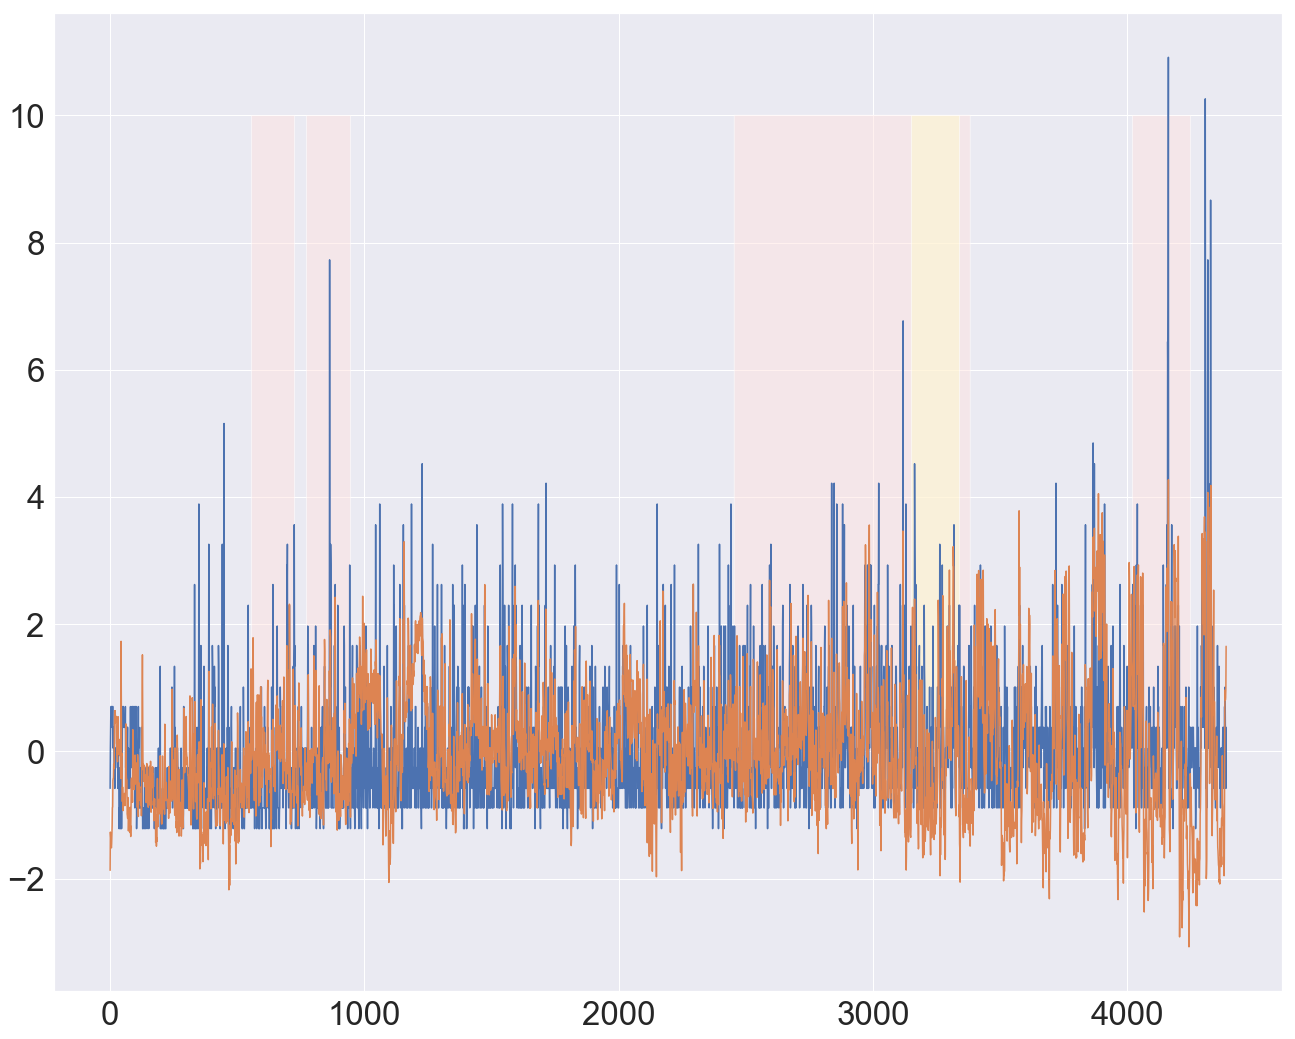

In [261]:
hight = 10
skip_start = 0
plt.fill_between(z[2][1][:], np.ones(z[0][1][:].shape[0])*hight, alpha=0.5, facecolor="mistyrose", label = "70% > Абсолютная Корреляция Пирсона > 60%")
plt.fill_between(z[1][1][:], np.ones(z[0][1][:].shape[0])*hight, alpha=0.5, facecolor="lemonchiffon", label = "90% > Абсолютная Корреляция Пирсона > 70 %")
plt.fill_between(z[0][1][:], np.ones(z[0][1][:].shape[0])*hight, alpha=0.5, facecolor="lightgreen", label = "Абсолютная Корреляция Пирсона > 90 %")
plt.plot(x)
plt.plot(y)

In [21]:
raw_data.info

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Channel 1, Channel 2, STI 014
    chs : list | 3 items (EEG: 2, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 124.99737505512384 Hz
    meas_date : tuple | 2019-01-31 13:39:52 GMT
    nchan : int | 3
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 249.99475011024768 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xpl